# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head(5) # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
training.get_word_Xlengths('BOOK')

(array([[-11,  57,   9,  58],
        [-11,  57,   5,  59],
        [-11,  57,   5,  59],
        [-11,  57,   5,  59],
        [-11,  57,   5,  59],
        [-11,  57,  14,  59],
        [-11,  53,  12,  53],
        [ -7,  55,   6,  53],
        [ -7,  55,   6,  53],
        [ -7,  55,   6,  53],
        [ -7,  55,  13,  58],
        [-12,  59,  20,  62],
        [-11,  39,   3,  39],
        [ -4,  42,   3,  39],
        [ -8,  40,   3,  39],
        [-11,  41,   5,  38],
        [-14,  42,   7,  39],
        [-14,  42,  11,  40],
        [-14,  42,  15,  42],
        [ 16,  37,  33,  53],
        [ 20,  41,  29,  48],
        [ 20,  41,  27,  41],
        [ 14,  42,  25,  42],
        [  8,  46,  22,  45],
        [  3,  45,  25,  46],
        [  0,  46,  25,  46],
        [-19,  84,  11, 106],
        [-19,  88,  11, 106],
        [-19,  88,  11, 104],
        [-19,  88,  11, 104],
        [-19,  88,  11, 104],
        [-18,  84,  12, 100],
        [-18,  84,  12, 100],
        [-

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [9]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [10]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()
df_std

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [11]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

norm = lambda w: (asl.df[w] - asl.df['speaker'].map(df_means[w]))/(asl.df['speaker'].map(df_std[w]))

asl.df['norm-rx'] = norm('right-x')
asl.df['norm-ry'] = norm('right-y')
asl.df['norm-lx'] = norm('left-x')
asl.df['norm-ly'] = norm('left-y')

In [12]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

radius = lambda x, y: ((asl.df[x]-asl.df['nose-x'])**2 + (asl.df[y]-asl.df['nose-y'])**2).apply(np.sqrt)
theta = lambda x, y: np.arctan2( (asl.df[x]-asl.df['nose-x']), (asl.df[y]-asl.df['nose-y']) )

asl.df['polar-rr'] = radius('right-x', 'right-y')
asl.df['polar-lr'] = radius('left-x', 'left-y')
asl.df['polar-rtheta'] = theta('right-x', 'right-y')
asl.df['polar-ltheta'] = theta('left-x', 'left-y')

In [13]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

scale = lambda w: (asl.df[w] - asl.df['speaker'].map(df_means[w]))/(asl.df['speaker'].map(df_std[w]))

delta = lambda s: (asl.df.groupby('speaker', sort=False)[s].diff()).fillna(0)
asl.df['delta-rx'] = delta('right-x')
asl.df['delta-ry'] = delta('right-y')
asl.df['delta-lx'] = delta('left-x')
asl.df['delta-ly'] = delta('left-y')

In [14]:
df_max = asl.df.groupby('speaker').max()
df_min = asl.df.groupby('speaker').min()

df_center = pd.DataFrame()
df_center['center1-x'] = df_means['nose-x']/2 #df_min['left-x']
df_center['center1-y'] = df_max['right-y']
df_center['center2-x'] = 3*df_means['nose-x']/2 #df_max['right-x']
df_center['center2-y'] = df_max['left-y']

df_center

,center1-x,center1-y,center2-x,center2-y
speaker,,,,
man-1,87.515878,251,262.547633,251
woman-1,81.327560,179,243.982680,191
woman-2,85.159487,214,255.478460,219


In [15]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

# TODO define a list named 'features_custom' for building the training set

# 1 - MinMaxScaler
xmin = lambda u: asl.df['speaker'].map(asl.df.groupby('speaker', sort=False)[u].min())
xmax = lambda v: asl.df['speaker'].map(asl.df.groupby('speaker', sort=False)[v].max())
scale = lambda w: (asl.df[w] - xmin(w))/(xmax(w) - xmin(w))

# 2 - nomalization
n_mean = lambda u: asl.df['speaker'].map(asl.df.groupby('speaker', sort=False)[u].mean())
n_std = lambda v: asl.df['speaker'].map(asl.df.groupby('speaker', sort=False)[v].std())
norm = lambda w: (asl.df[w] - n_mean(w))/(n_std(w))

# 3 - distance w.r.t 2 centers
radius1 = lambda x, y: ((asl.df[x]-asl.df['speaker'].map(df_center['center1-x']))**2 + (asl.df[y]-asl.df['speaker'].map(df_center['center1-y']))**2).apply(np.sqrt)
radius2 = lambda x, y: ((asl.df[x]-asl.df['speaker'].map(df_center['center2-x']))**2 + (asl.df[y]-asl.df['speaker'].map(df_center['center2-y']))**2).apply(np.sqrt)
theta1 = lambda x, y: np.arctan2( (asl.df[x]-asl.df['speaker'].map(df_center['center1-y'])), (asl.df[y]-asl.df['speaker'].map(df_center['center1-x']) ))
theta2 = lambda x, y: np.arctan2( (asl.df[x]-asl.df['speaker'].map(df_center['center2-y'])), (asl.df[y]-asl.df['speaker'].map(df_center['center2-x']) ))

# My custom features
features_custom = ['polar1-r', 'polar2-r', 'polar1-theta', 'polar2-theta']

# 1
#asl.df['sright-x'] = scale('polar-rr')
#asl.df['sright-y'] = scale('polar-lr')
#asl.df['sleft-x'] = scale('polar-rtheta')
#asl.df['sleft-y'] = scale('polar-ltheta')

# 1
#asl.df['npolar-rr'] = norm('polar-rr')
#asl.df['npolar-lr'] = norm('polar-lr')
#asl.df['npolar-rtheta'] = norm('polar-rtheta')
#asl.df['npolar-ltheta'] = norm('polar-ltheta')

# 3
asl.df['polar1-r'] = radius1('right-x', 'right-y')
asl.df['polar2-r'] = radius2('left-x', 'left-y')
asl.df['polar1-theta'] = theta1('right-y', 'right-x')
asl.df['polar2-theta'] = theta2('left-y', 'left-x')

# 4
#asl.df['dist-x'] = asl.df['right-x']-asl.df['left-x']
#asl.df['dist-y'] = asl.df['right-y']-asl.df['left-y']

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**
I will analyze the various attempts I tried. Each time I put a #{number} that corresponds to the corresponding comment in my python code above.

**#1** - MinMaxScaler. I created a MinMaxScaler and used it to scale right-x, right-y (or event polar radius) and so on. Actually when I evaluate the model using those features, it performs decrease as regards to the features_polar. It is understandable as polar coordinate fit more the natural movement of the hands that much more likely describe curves in the 2-D spaces than straight-line. I got WER around 0.7 while with features_polar I get at best around 0.53

**#2** - Normalization. I used normalization and applied it to polar coordinates. While with polar features I could achieve a a WER of 0.53, by normalising features polar I achieve a WER 0.58 to 0.62. I would have thought it would have peformed better using normalization. It isn't the case. I might be because we don't have enough training data

**#3** - I think that, rather than using polar coordinate w.r.t the nose as center, we could use 2 coordinate center w.r.t a pt that would be roughly at the bottom 1/4 of the video and the other being at the bottom 3/4 of the video (hence rougly the 2 circles would be situated at the elbow). Intuitively, I think that using polar coordinate for the right hand w.r.t the center right elbow and polar coordinate with left hand w.r.t the center left elbow should improve the accuracy as we might think that the movements of the hand would rather describe curves/circles w.r.t to those 2 centers instead of just w.r.t the nose. Using thos features leads to a WER of 0.58 while polar features leads to 0.53 at best. I can be understandable as those "elbow centers" are roughly calculated and that, as I have 2 different referentials, I loose one information (the place of one hand relatively to the other one) which can be corrected if I add other features. But in this case I'm afraid adding too much features will lead to overfitting as we don't have enough training data.

**#4** - I computed the distance between left hand and right hand. It could be a good indicator because some words need 2 hands and others need one. also some words should be mimed with two hand very close to each other while other words should be mimed with 2 hands separated from each other. I used them with polar features

I also used a combination of other features among them and try also to add more than 4 features (but not to much to avoid overfitting). In the end I think the best remains the polar features or a combinaison of several other features. I stick to **#3** as I think those are quite intuitive features

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [16]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.013s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [17]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.113812743319


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [18]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        #print("variance = ", np.diag(model.covars_[i]))
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [19]:
my_testword = 'JOHN'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for JOHN is 3
hidden state #0
mean =  [ -21.021061     38.51024848    1.39270426  126.26889606]
variance =  [  52.50015648   98.66709622  168.30770438  300.17991637]

hidden state #1
mean =  [ -24.92747926   61.93716342   33.40672725  178.81045936]
variance =  [  80.27423577  400.10409204   82.68869582   16.54418295]

hidden state #2
mean =  [ -11.7408851    77.82681668    4.81285139  134.10189748]
variance =  [  86.14500669  328.74048785  313.66048313  140.88634919]

logL = -18266.910547407173


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [20]:
%matplotlib inline

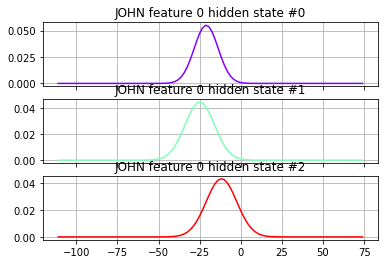

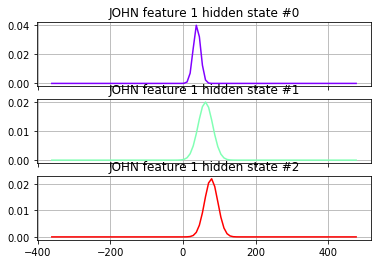

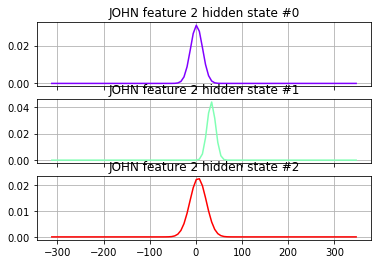

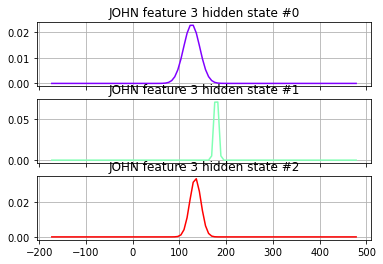

In [21]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `SelectorModel` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [22]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
myDict = training.get_all_Xlengths()
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [23]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'BOOK' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[ 6  7  8  9 10 11 12 13 14 15 16 17] Test fold indices:[0 1 2 3 4 5]
Train fold indices:[ 0  1  2  3  4  5 12 13 14 15 16 17] Test fold indices:[ 6  7  8  9 10 11]
Train fold indices:[ 0  1  2  3  4  5  6  7  8  9 10 11] Test fold indices:[12 13 14 15 16 17]


##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation

The advantages of scoring model topologies with **DIC** over BIC is presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf).  DIC scores the discriminant ability of a training set for one word against competing words.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [24]:
words_to_train = ['FISH'] #, 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN', 'HOMEWORK', 'WRITE'
import timeit
%load_ext autoreload

In [25]:
# TODO: Implement SelectorCV in my_model_selector.py
%autoreload 2
from my_model_selectors import SelectorCV

training = asl.build_training(features_polar)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 13 states with time 0.5970401975308641 seconds


In [26]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
%autoreload 2
from my_model_selectors import SelectorBIC

training = asl.build_training(features_polar)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 10 states with time 0.27525767901234577 seconds


In [233]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
%autoreload 2
from my_model_selectors import SelectorDIC

training = asl.build_training(features_polar)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 10 states with time 38.49151486419942 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**
**SelectorBIC** model is the best model in term of WER (see PART 3) and in term of time. we can see that it run faster than **SelectorCV** (which is normal as in in CV we have to do cross-validation). **SelectorCV** is a good Selector, actually it is a naive selector but using cross-validation ensures the result to be much more accurate. The downsize is that it takes a little bit longer to compute. Finally **SelectorDIC** seems to be the worst. It doesn't lead to WER that is better than the 2 others and takes lots of time to compute as for each __sequence__ we need to compute the likelihood of the sequence and the mean of all the remaining likelihood (anti-likelihood). Hence **SelectorBIC** and **SelectorCV** appear to be better choice

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [234]:
from asl_test import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 451.471s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [27]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [28]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [29]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [231]:
# TODO Choose a feature set and model selector
features = features_custom # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5955056179775281
Total correct: 72 out of 178
Video  Recognized                                                    Correct
    2: *FRANK *ARRIVE *ARRIVE                                        JOHN WRITE HOMEWORK
    7: JOHN *DECIDE GO CAN                                           JOHN CAN GO CAN
   12: *MARY CAN *ARRIVE CAN                                         JOHN CAN GO CAN
   21: *LIKE *NEW WONT *VEGETABLE *CAR *DECIDE EAT CHICKEN           JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *MARY LIKE *MARY *IX-1P *LIKE                                 JOHN LIKE IX IX IX
   28: *ANN *ANN *ANN *LIKE *ANN                                     JOHN LIKE IX IX IX
   30: *IX *BILL IX *BILL IX                                         JOHN LIKE IX IX IX
   36: MARY *JOHN *IX *WOMAN *MARY *IX                               MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *MARY *YESTERDAY *SUE *BILL                              JOHN IX THINK MARY LOVE
   43: JOHN *JOHN BUY HOUSE         

In [232]:
# TODO Choose a feature set and model selector
features = features_polar # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5842696629213483
Total correct: 74 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *HAVE *IX *WHAT                                          JOHN CAN GO CAN
   12: JOHN CAN *WHAT CAN                                            JOHN CAN GO CAN
   21: JOHN *HOMEWORK WONT *JOHN *CAR *CAR EAT *TOMORROW             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *TELL *LOVE *TELL *LOVE                                  JOHN LIKE IX IX IX
   28: JOHN *TELL *MARY *TELL *LOVE                                  JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY IX                                      JOHN LIKE IX IX IX
   36: *JOHN VEGETABLE *GIRL *GIVE *BILL *MARY                       MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *BILL *FUTURE1 *JOHN *SHOOT                              JOHN IX THINK MARY LOVE
   43: JOHN *SHOULD BUY HOUSE       

In [30]:
# TODO Choose a feature set and model selector
features = features_polar # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5224719101123596
Total correct: 85 out of 178
Video  Recognized                                                    Correct
    2: JOHN *BROTHER *GIVE1                                          JOHN WRITE HOMEWORK
    7: JOHN CAN GO *ARRIVE                                           JOHN CAN GO CAN
   12: JOHN *WHAT *JOHN CAN                                          JOHN CAN GO CAN
   21: JOHN *NEW *JOHN *FUTURE *GIVE1 *WHAT *FUTURE *WHO             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *WHO IX                                           JOHN LIKE IX IX IX
   28: JOHN *MARY IX IX IX                                           JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *IX VEGETABLE *GIVE *GIVE *MARY *MARY                         MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GO *GIVE MARY *MARY                                     JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE BUY HOUSE       

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**
You see the error result of 3 of combinations of features and model selectors above. The best combination _here_ seems to be SelectorBIC and features_polar as it leads to the lower WER: 0.53 and it takes less time than SelectorCV to compute. The worst is SelectorDIC. It takes **1h25** to compute on my own computer and doesn't guarantee to have better result _(cf table below)_. To improve our WER we can use another model like a **Grammar Model** or a **Language model** and combine them with our **Acoustic Model** using Bayes Rules and some algorithms such as:
+ N-best
+ Viterbi algorithm
+ ..


   WER           |  SelectorDIC  |  SelectorBIC  | SelectorCV
  -------------  | ------------- | ------------- | ------------
**features_polar**   | 0.561  | 0.539  | 0.561
**features_norm**   | 0.617  | 0.595  | 0.612
**features_delta**  | 0.651  | 0.640  | 0.640

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [31]:
from asl_test import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 26.026s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [205]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,-2564.662695,-41956.468452,-2607.661913,-283.236620,-1914.870126,-361.960448,-2788.373706,-996.866290,-4494.410087,-506.014587,...,-1570.826117,-204.394372,-1808.252197,-281.594959,-211.611880,-710.683687,-657.289539,-754.633694,-9815.468262,-297.246080
1,-6791.690644,-36160.004699,-9809.478432,-118.942572,-16939.812725,-339.938120,-2762.903680,-113.149854,-3834.421244,-701.495432,...,-135.571999,-374.557539,-1664.036269,-341.874211,-111.098536,-3134.871283,-415.246557,-1494.193684,-113.794489,-1495.640659
2,-9576.855303,-154469.113258,-16073.901762,-318.667096,-25629.382095,-907.851176,-7178.991459,-879.147700,-3441.069400,-1229.191798,...,-891.254578,-711.496965,-2125.926160,-767.909074,-483.978522,-4347.725285,-1412.953319,-1869.519352,-3230.074501,-965.782421
3,-1061.709747,-466692.858336,-2555.973123,-252.589494,-526.346339,-260.431204,-198.966164,-997.240149,-33897.899104,-711.825376,...,-3949.501739,-217.816749,-15343.585503,-571.705613,-565.158810,-2694.318006,-267.511192,-508.134793,-50457.361807,-521.223356
4,-1462.548501,-227504.583968,-3113.233070,-62.168304,-2726.599622,-57.427115,-140.806752,-144.376407,-846.567498,-47.469508,...,-231.796585,-64.713586,-600.012881,-50.957518,-208.252232,-1359.808704,-144.034247,-812.568059,-3369.306540,-346.633865


In [87]:
import arpa

models = arpa.loadf("aslr.lm")
lm = models[0]

# list of the 112 words
words = df_probs.keys().tolist()

# n-best words according to their logLikelihood
topn_v = np.fliplr(np.sort(df_probs,axis=1)[:,-6:]) #[:,-6:] --> 6 best words
topn_pos = np.fliplr(np.array(np.argsort(df_probs,axis=1).iloc[:,-6:])) # corresponding position

topn_d = {}
"""for i in range(test_set.num_items):
    for idx, value in zip(topn_pos[i], topn_v[i]):
        if i in topn_d:
            topn_d[i].append((words[idx], value))
        else:
            topn_d[i] = []
            topn_d[i].append((words[idx], value))"""
            
for idx, val in test_set.sentences_index.items():
    sentence_len = len(val)
    for i in val:
        # keep only c words where c dicrease with the length of the real sentence
        c = 6 if sentence_len <= 4 else 5 if sentence_len <= 5 else 4 if sentence_len <= 6 else 3
        for idx, value in zip(topn_pos[i], topn_v[i]):
            if c == 0:
                break
            c -= 1
            if i in topn_d:
                topn_d[i].append((words[idx], value))
            else:
                topn_d[i] = []
                topn_d[i].append((words[idx], value))
            
# add real words  
# for cheater only :p --> lead to WER of 19% 
# if C = 1e9 but it is cheating (see explanation at the end)

#for i in range(test_set.num_items):
#    words = [w[0] for w in topn_d[i]]
#    new_w = test_set.wordlist[i]
#    if new_w not in words:
#        try:
#            topn_d[i].append((new_w, df_norm[new_w][i]))
#        except:
#            pass
#topn_d

In [80]:
import itertools

def show_errors2(guesses, test_set):
    S = 0
    N = len(test_set.wordlist)
    num_test_words = len(test_set.wordlist)
    if len(guesses) != num_test_words:
        print("Size of guesses must equal number of test words ({})!".format(num_test_words))
    for word_id in range(num_test_words):
        if guesses[word_id] != test_set.wordlist[word_id]:
            S += 1

    return float(S) / float(N)

def sentences_score_by_sample(topn_d, idx_list, sentence, C):
    """ create dict of one video sentence numbers with dict of word sequence with their corresponding log likelihood value
    :param topn_d: dict of the n best words according to their loglikelihood
    :param idx_list: idx_list
    :param sentence: correct sentence
    :param C: factor in the formula argmax{log(O|W) + C*log(W)} 
    :return: C to use in the formula argmax{log(O|W) + C*log(W)}
    {
    v0: {"MY SENTENCE1": logP, "MY SENTENCE2": logP, "MY SENTENCE3": logP}, 
    v1: {"OTHER EXAMPLE SENTENCE1": logP, "OTHER EXAMPLE SENTENCE2": logP, "OTHER EXAMPLE SENTENCE3": logP},
    } 
    where v# is video number
    """
    d = {}
    
    # list of list of tuple representing the best word and his log likelihood value
    # [[('MARY', -178.48),('NOT', -173.62),..],[('BOOK', -113.14),('BOOK', -113.14),..],...]
    word_and_score = [topn_d[i] for i in idx_list]
        
    for comb in itertools.product(*word_and_score):
        # combinaison of sentence build from word_and_score list
        sentence_c = " ".join([w[0] for w in comb])
        try:
            prior = lm.log_s(sentence_c)
        except:
            continue
        # value = {log(O|W) + C*log(W)}
        value = sum([w[1] for w in comb]) + C*prior
        d[sentence_c] = value
        #if sentence == "JOHN LIKE IX IX IX":
        #    print(sentence_c, sum([w[1] for w in comb]))
        #    print(prior)
        #    print()
        
    return d
        

def sentences_score(topn_d, test_set, C):
    """ create dict of video sentence numbers with dict of word sequence with their corresponding log likelihood value
    :param topn_d: dict of the n best words according to their loglikelihood
    :param csvfile: test_set
    :param C: to use in the formula argmax{log(O|W) + C*log(W)}
    :return: dict
    {
    v0: {"MY SENTENCE1": logP, "MY SENTENCE2": logP, "MY SENTENCE3": logP}, 
    v1: {"OTHER EXAMPLE SENTENCE1": logP, "OTHER EXAMPLE SENTENCE2": logP, "OTHER EXAMPLE SENTENCE3": logP},
    } 
    where v# is video number
    """
    my_new_d = {}
    for idx, val in test_set.sentences_index.items():
        my_new_d[idx] = sentences_score_by_sample(topn_d, val, " ".join(test_set.wordlist[val[0]: val[-1]+1]), C)
    return my_new_d

#dict_sentences_score = sentences_score(topn_d, test_set, 7)

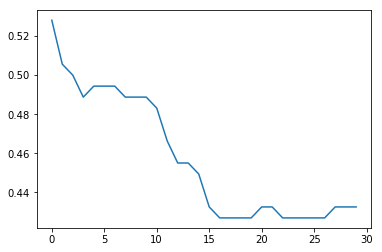

In [84]:
def get_guess(final_dic):
    guesses_f = []
    for idx, value in final_dic.items():
        sentence_max = max(final_dic[idx], key=final_dic[idx].get)
        for w in sentence_max.split():
            guesses_f.append(w)
    return guesses_f

hist = []
for i in range(30):
    dict_sen_score = sentences_score(topn_d, test_set, i)
    new_g = get_guess(dict_sen_score)
    hist.append(show_errors2(new_g, test_set))

plt.plot(hist)

In [86]:
dict_sentences_score = sentences_score(topn_d, test_set, 25)
new_g = get_guess(dict_sentences_score)
show_errors(new_g, test_set)


**** WER = 0.42696629213483145
Total correct: 102 out of 178
Video  Recognized                                                    Correct
    2: JOHN *BROTHER *ARRIVE                                         JOHN WRITE HOMEWORK
    7: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   12: JOHN CAN *JOHN CAN                                            JOHN CAN GO CAN
   21: JOHN *NEW *CAR *FUTURE *CAR *WHAT *JOHN *WHO                  JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE IX IX IX                                            JOHN LIKE IX IX IX
   28: JOHN *IX IX IX IX                                             JOHN LIKE IX IX IX
   30: JOHN LIKE IX IX IX                                            JOHN LIKE IX IX IX
   36: MARY VEGETABLE *GIVE *GIVE *LOVE *MARY                        MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GO *VISIT MARY *MARY                                    JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE BUY HOUSE     

### In the following cells I used Viterbi algorithm ###
I was not sure as if I have to use Viterbi algorithm or not. Actually, after reading on the subject I think viterbi algorithm could be useful. I used the Decoder class from https://phvu.net/2013/12/06/sweet-implementation-of-viterbi-in-python/
Also don't hesitate to see my intervention in this Udacity post (about how to tackle the problem): https://discussions.udacity.com/t/slm-data-for-this-asl-dataset/230822

In [88]:
import numpy as np
 
class Decoder(object):
    def __init__(self, initialProb, transProb, obsProb):
        self.N = initialProb.shape[0]
        self.initialProb = initialProb
        self.transProb = transProb
        self.obsProb = obsProb
        assert self.initialProb.shape == (self.N, 1)
        assert self.transProb.shape == (self.N, self.N)
        assert self.obsProb.shape[0] == self.N
 
    def Obs(self, obs):
        return self.obsProb[:, obs, None]
 
    def Decode(self, obs):
        trellis = np.zeros((self.N, len(obs)))
        backpt = np.ones((self.N, len(obs)), 'int32') * -1
 
        # initialization
        trellis[:, 0] = np.squeeze(self.initialProb * self.Obs(obs[0]))
 
        for t in range(1, len(obs)):
            trellis[:, t] = (trellis[:, t-1, None].dot(self.Obs(obs[t]).T) * self.transProb).max(0)
            backpt[:, t] = (np.tile(trellis[:, t-1, None], [1, self.N]) * self.transProb).argmax(0)
        # termination
        tokens = [trellis[:, -1].argmax()]
        for i in range(len(obs)-1, 0, -1):
            tokens.append(backpt[tokens[-1], i])
        return tokens[::-1]

In [148]:
# transition matrix for each word : P(WORD1|WORD2)
# where the row index correspond to the index of the words, hence :
# probability p(APPLE|ARRIVE) corresponds to
# lm.log_p("ARRIVE APPLE") = df_trans['APPLE'][3]
df_norm = df_probs
import arpa
models = arpa.loadf("aslr.lm")
lm = models[0]
words = df_norm.keys().tolist()
trans_l = []
for w1 in words:
    row = {}
    for w2 in words:
        sen = w1 + " " + w2
        try:
            row[w2] = lm.p(sen)
        except:
            row[w2] = 0.00001
    trans_l.append(row)
df_trans = pd.DataFrame(data=trans_l)
df_trans.head()

,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,0.003363,0.003363,0.004142,0.016768,0.004142,0.005284,0.003363,0.016768,0.003363,0.004142,...,0.004142,0.012174,0.003363,0.030550,0.023659,0.003363,0.007581,0.004142,0.003363,0.009877
1,0.003363,0.003363,0.004142,0.016768,0.004142,0.281755,0.003363,0.016768,0.003363,0.004142,...,0.004142,0.012174,0.003363,0.030550,0.023659,0.003363,0.007581,0.004142,0.003363,0.009877
2,0.003363,0.003363,0.004142,0.016768,0.004142,0.005284,0.003363,0.016768,0.003363,0.004142,...,0.004142,0.012174,0.003363,0.030550,0.161894,0.003363,0.007581,0.004142,0.003363,0.009877
3,0.000551,0.000551,0.000678,0.002746,0.000678,0.000865,0.000551,0.002746,0.000551,0.000678,...,0.000678,0.001994,0.000551,0.005003,0.020669,0.000551,0.001242,0.000678,0.000551,0.001618
4,0.003363,0.003363,0.004142,0.016768,0.004142,0.005284,0.003363,0.016768,0.003363,0.004142,...,0.004142,0.012174,0.003363,0.099667,0.023659,0.003363,0.007581,0.004142,0.003363,0.078995


In [221]:
df_prob_t = df_probs.transpose()

In [225]:
# try to normalize probabilities table...
df_prob_slice = np.exp(df_prob_t)
df_prob_slice_temp = df_prob_slice.transpose() - df_prob_slice[df_prob_slice > -1e20].min(axis=1)
df_prob_slice_temp2 = df_prob_slice_temp.transpose()
df_prob_slice_final = (df_prob_slice_temp2 - df_prob_slice_temp2.mean()) / (df_prob_slice_temp2.max() - df_prob_slice_temp2.min())
df_prob_slice_f = np.exp(df_prob_slice_final)/np.sum(np.exp(df_prob_slice_final), axis=0)
df_prob_slice_f = df_prob_slice_f.fillna(0)
df_prob_slice_f.head()


,0,1,2,3,4,5,6,7,8,9,...,168,169,170,171,172,173,174,175,176,177
ALL,0.008787,0.008794,0.008794,0.008794,0.008794,0.008794,0.008794,0.008794,0.008794,0.008771,...,0.008794,0.008794,0.008794,0.008794,0.008794,0.008789,0.008794,0.008783,0.008794,0.008794
ANN,0.008787,0.008794,0.008794,0.008794,0.008794,0.008794,0.008794,0.008794,0.008794,0.008771,...,0.008794,0.008794,0.008794,0.008794,0.008794,0.008789,0.008794,0.008783,0.008794,0.008794
APPLE,0.008787,0.008794,0.008794,0.008794,0.008794,0.008794,0.008794,0.008794,0.008794,0.008771,...,0.008794,0.008794,0.008794,0.008794,0.008794,0.008789,0.008794,0.008783,0.008794,0.008794
ARRIVE,0.008787,0.008794,0.008794,0.008794,0.008794,0.008794,0.023904,0.008794,0.008794,0.008771,...,0.008794,0.008794,0.008794,0.008794,0.008794,0.008789,0.008794,0.008783,0.008794,0.008794
BILL,0.008787,0.008794,0.008794,0.008794,0.008794,0.008794,0.008794,0.008794,0.008794,0.008771,...,0.008794,0.008794,0.008794,0.008794,0.008794,0.008789,0.008794,0.008783,0.008794,0.008794


In [226]:
# return only the result for the first setence
# here JOHN LOVE MARY is returned instead of JOHN WRITE HOMEWORK
# JOHN LOVE MARY (it's it beautiful ?)
all_tab = np.array(df_prob_t)

obs=np.array(df_prob_slice_f.ix[:,0:2])
transition=np.array(df_trans)

statenames = df_norm.keys().tolist()
rownames = words

init=np.expand_dims(np.array(obs[:,0]),1)
decoder = Decoder(init, transition, obs)

states =  decoder.Decode(np.arange(3))
result = np.array(statenames)[states].tolist()
sentence = df_prob_slice.columns.tolist()
resultTagged = zip(sentence,result)
print([u for u in resultTagged])

[(0, 'JOHN'), (1, 'LOVE'), (2, 'MARY')]


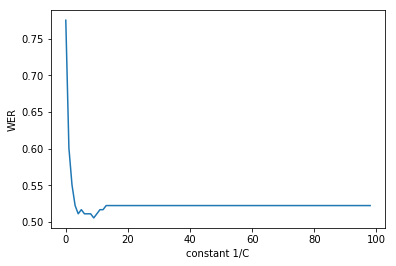

In [230]:
def test_viterbi(df_trans):
    n_g = []
    transition=np.array(df_trans)
    for video, seq in test_set.sentences_index.items():
        df_prob_s = df_prob_slice_f.ix[:,seq[0]:seq[-1]]
        obs=np.array(df_prob_s)
        init=np.expand_dims(np.array(obs[:,0]),1)

        decoder = Decoder(init, transition, obs)
        states =  decoder.Decode(np.arange(len(seq)))
        result = np.array(statenames)[states].tolist()
        for v in result:
            n_g.append(v)
    return n_g

hist = []
for i in range(1,100):
    df_trans_copy = np.power(df_trans, 1/i)
    n_g = test_viterbi(df_trans_copy)
    hist.append(show_errors2(n_g, test_set))
plt.plot(hist)
plt.xlabel("constant 1/C")
plt.ylabel("WER")

Well Actually I think there might be a way to use trellis/viterbi/N-best algorithms to improve the WER. So if you can help me to understand how I can improve even more the accuracy of the model let me know. I think to improve even more the model we can improve our HMM too.

**Note** : If I add the true words to the language model and if I use C=1e9 (C a very big number) I can achieve a WER of 19%. But it isn't a good result as in this case my LM overwhelm my AM and hence I'm not using my AM. In this case I give me a good accuracy because we don't have lot's of training data. See all the debate in this Udacity post:
https://discussions.udacity.com/t/slm-data-for-this-asl-dataset/230822